In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
class Network:
    def __init__(self, layers = [784, 400, 200, 10]):
        self.layers = layers
        self.weights = []
        self.masks = []
        self.weights_dim = [[layers[i], layers[i+1]] for i in range(len(layers) - 1)]
        for i in self.weights_dim:
            self.masks.append(tf.placeholder(tf.float32, i))
            self.weights.append(
                [tf.Variable(tf.truncated_normal(i, stddev=0.1)), tf.Variable(tf.zeros(i[1:]))])
        self.session = tf.Session()
    
    def build_graph(self):
        x = self.x = tf.placeholder(tf.float32, [None, self.layers[0]])
        y_ = self.y_ = tf.placeholder(tf.float32, [None, self.layers[-1]])
        
        y = x
        for w, b in self.weights[:-1]:
            y = tf.nn.sigmoid(tf.matmul(y, w) + b)
            
        w, b = self.weights[-1]
        y = tf.nn.softmax(tf.matmul(y, w) + b)
        
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        self.correct_rate = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
        self.train_step = tf.train.AdadeltaOptimizer(learning_rate = 1, rho = 0.5).minimize(cross_entropy)
        
        #Brain damage
        self.delete_neurons = []
        for i in range(len(self.weights)):
            self.delete_neurons.append(tf.assign(self.weights[i][0], tf.mul(self.weights[i][0], self.masks[i])))
            
        self.init = tf.initialize_all_variables()
        
    def brain_damage(self, layer, rate):
        W = self.session.run(self.weights[layer][0])
#        print(W.shape)
        wsum = list(np.sum(np.absolute(W), axis = 1))
        wsorted = sorted([(i, wsum[i]) for i in range(len(wsum))], key = lambda x: x[1])
        to_delete = [x[0] for x in wsorted][:int(rate * len(wsorted))]
#        print(to_delete)
        mask_out = np.ones(self.weights_dim[layer])
        mask_in = np.ones(self.weights_dim[layer - 1])
        for i in to_delete:
            for j in range(self.weights_dim[layer][1]):
                mask_out[i, j] = 0
            for j in range(self.weights_dim[layer - 1][0]):
                mask_in[j, i] = 0
                
        self.session.run(self.delete_neurons[layer], feed_dict = {self.masks[layer] : mask_out})
        self.session.run(self.delete_neurons[layer - 1], feed_dict = {self.masks[layer - 1] : mask_in})
        
    def init_variables(self):
        self.session.run(self.init)
        
    def train(self, steps):
        for i in range(steps):
            batch_xs, batch_ys = mnist.train.next_batch(100)
            self.session.run(self.train_step, feed_dict = {self.x : batch_xs, self.y_ : batch_ys})
            
    def layer_utility(self, layer):
        W = self.session.run(self.weights[layer][0])
        wsum = list(np.sum(np.absolute(W), axis = 1))
        plt.hist(wsum)
            
    def validate(self):
        return self.session.run(self.correct_rate, feed_dict={self.x: mnist.test.images, self.y_: mnist.test.labels})
    
    def delete_layer(self, layer):
        self.session.run(self.delete_neurons[layer], feed_dict = {self.masks[layer] : np.zeros(self.weights_dim[layer])})
     
    def restore_layer(self, layer):
        self.session.run(self.delete_neurons[layer], feed_dict = {self.masks[layer] : np.ones(self.weights_dim[layer])})
        

        
            
        

In [3]:
n = Network()
n.build_graph()
n.init_variables()
n.train(2000)
print(n.validate())

0.9217


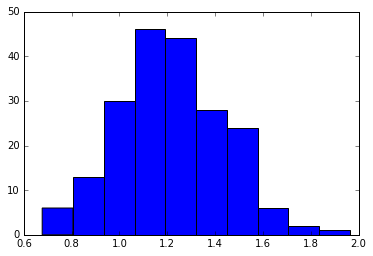

In [ ]:
n.layer_utility(2)

In [ ]:
previous_step = -100 
rate = 0.05
rate_decay = 1.0
for i in range(15):
    n.brain_damage(2, rate)
    n.brain_damage(1, rate)
    n.train(2000)
    current_step = n.validate()
    rate = rate * rate_decay
    print(current_step)

0.9369
0.9474
0.9529


In [ ]:
n.layer_utility(2)

In [ ]:
n.session.run(n.weights[1][0])